# Almacén de objetos, utilizando robots con inteligencia artificial

En este problema utilizaremos Q-learning para entrenar robots que sean capaces de cargar objetos y llevarlos de un lugar a otro en un almacén.

El objetivo de los robots será el de transportar objetos de diferentes partes del almacén al punto de empaquetamiento y visceversa.

In [5]:
#Importamos librerías
import numpy as np

En este problema utilizaremos una malla para representar la distribución del almacén

In [6]:
#Definimos las dimensiones del entorno
environment_rows = 11
environment_columns = 11
#Inicializamos la tabla Q con valores de cero, la tabla debe tener las mismas dimensiones que nuestro entorno
#Además añadimos una tercera dimensión que representa las posibles acciones que pueden ser realizadas
q_values = np.zeros((environment_rows, environment_columns, 4))

Las acciones que podrá realizar el robot son 4: moverse hacia arriba, derecha, abajo e izquierda

In [7]:
#Definimos las acciones como:
#0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

In [8]:
#Creamos un array para almacenar la recompensa para cada estado, el array debe tener las misma dimensiones que el entorno
#También inicializamos la recompensa en -100
rewards = np.full((environment_rows, environment_columns), -100.)
rewards[0, 5] = 100. #Establecemos la recompensa para la zona de carga con un valor de 100

#Definimos la ubicación de los pasillos
aisles = {}
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]

#Establecemos la recompensa para los pasillos
for row_index in range(1, 10):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = -1.

#Mostramos la matriz de recompensas
for row in rewards:
  print(row)

[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]


Para visualizar mejor la distribución tenemos la siguiente figura, donde cada cuadro negro representa una estantería, con una recompensa de -100, cada cuadro blanco representa un espacio de los pasillos por los que puede moverse el robot, con una recompensa de -1, y por último el cuadro verde que representa el punto de empaquetamiento con una recompensa de 100

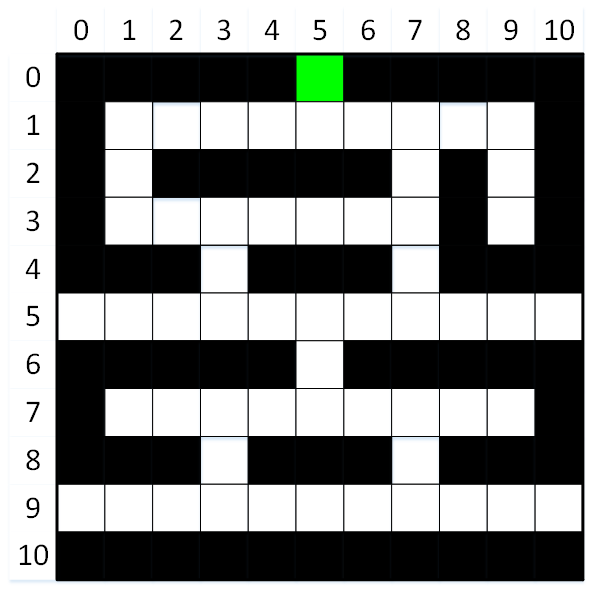

In [9]:
#Definimos una función que determina si la ubicación es un estado terminal (estantería/cuadro negro o punto de empaquetamiento/cuadro verde)
def is_terminal_state(current_row_index, current_column_index):
  #Si la recompensa es = -1, entonces no es un estado terminal ya que es un pasillo
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True
#Definimos una función que escogerá una ubicación no terminal de manera aleatoria
def get_starting_location():
  #Obtenemos una fila y columna aleatorias
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)
  #Bucle que obtiene una fila y columna aleatoria hasta que sea un estado no terminal (casilla blanca)
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index

#Definimos el algoritmo epsilon-greedy que escogerá la siguiente acción a tomar
def get_next_action(current_row_index, current_column_index, epsilon):
  #Si el valor aleatorio elegido es menor a epsilon escoge el mejor valor posible de la tabla Q para este estado
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #Escoge una acción aleatoria
    return np.random.randint(4)

#Definimos una función que obtendrá la siguiente ubicación basada en la acción elegida
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#Definimos una función que obtendrá el camino más corto entre cualquier ubicación que el robot tiene permitido estar
#y la ubicación del punto de empaquetamiento
def get_shortest_path(start_row_index, start_column_index):
  #Retorna inmediatamente si la ubicación es un estado terminal
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #Si la ubicación es un lugar válido
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #Continua moviéndose hasta que llegue al punto de empaquetamiento
    while not is_terminal_state(current_row_index, current_column_index):
      #Obtiene la mejor acción posible
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #Mueve hasta la siguiente ubicación en el camino y añade la nueva ubicación a la lista
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

In [10]:
#Parámetros de entrenamiento
epsilon = 0.9 #El porcentaje de tiempo en el que deberíamos tomar la mejor acción en lugar de una aleatoria
discount_factor = 0.9 #Factor de descuento para recompensas futuras
learning_rate = 0.9 #La razón en la que aprende el agente
#Ejecutamos con 1000 episodios
for episode in range(1000):
  #Obtiene la ubicación de inicio para un episodio
  row_index, column_index = get_starting_location()

  #Continua moviéndose hasta llegar a un estado terminal
  #(Hasta llegar a una estantería o al punto de empaquetamiento)
  while not is_terminal_state(row_index, column_index):
    #Escoge qué accion tomar
    action_index = get_next_action(row_index, column_index, epsilon)

    #Realiza la acción escogida y se mueve a la siguiente ubicación
    old_row_index, old_column_index = row_index, column_index #Almacena la fila y columna anteriores
    row_index, column_index = get_next_location(row_index, column_index, action_index)

    #Recibe la recompensa por moverse de ubicación y calcula la diferencia temporal
    reward = rewards[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #Actualiza la tabla Q para el estado y acción anteriores
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Entrenamiento completado')

Training complete!


Una vez completado el entrenamiento, usaremos algunas ubicaciones de prueba y visualizaremos paso por paso la ruta que el robot considera más efectiva.

In [11]:
#Visualizamos algunas rutas para diferentes ubicaciones
print(get_shortest_path(9, 10))
print(get_shortest_path(5, 0))
print(get_shortest_path(9, 5))

[[9, 10], [9, 9], [9, 8], [9, 7], [8, 7], [7, 7], [7, 6], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]
[[5, 0], [5, 1], [5, 2], [5, 3], [4, 3], [3, 3], [3, 2], [3, 1], [2, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [0, 5]]
[[9, 5], [9, 6], [9, 7], [8, 7], [7, 7], [7, 6], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]


Por último, para realizar el movimiento del robot desde la zona de empaquetamiento hasta cualquier otro punto del almacén, solo debemos invertir la ruta obtenida de dicho punto a la zona de empaquetamiento.

In [ ]:
#Visualizamos un ejemplo de ruta invertida
path = get_shortest_path(5, 2)
path.reverse()
print(path)